**Шаг 1. Загрузим данные и подготовим их к анализу**

In [1]:
# импортируем библеотку pandas и библиотки для построения графиков,  
# высокоуровневых математический функций, вычисления факториала 
# и для задания распределения по мат. ожиданию
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import factorial
from scipy import stats as st

# задействуем фичи, от ошибок при повторном использовании одного и того же df
# и для отображения трёх символов после запятой для всех значений с плавающей запятой
# малые финансовые переменные любят 2 значения после запятой 
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
# загрузим датасеты
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
# изучим данные
for df in [visits, orders, costs]:   
    display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

In [4]:
# изучим данные
for df in [visits, orders, costs]:   
    display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

In [5]:
for df in [visits, orders, costs]:   
    display(df.head())

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [6]:
# переведём тип данных в каждой колонке в правильный и проверим 
activity = visits # сохраним датафрейм visits для дальнейших интераций
purchase = orders # сохраним датафрейм orders для дальнейших интераций
for df in [visits]:
    for column in df.columns:
        if 'Ts' in column or 'dt' in column:
             df[column] = pd.to_datetime(df[column])          

In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null datetime64[ns]
Source Id    359400 non-null int64
Start Ts     359400 non-null datetime64[ns]
Uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


**Вывод**

Данные в колонках верные, пропусков нет. Не соотвествует только формат дат. Частично преобразовали формат в сете visits, остальные преобразуем по ходу анализа, т.к. сейчас это делеать не совсем комфортно.

**Шаг 2. Постройте отчёты и посчитайте метрики**

**Продукт**

*Сколько людей пользуются сайтом в день, неделю, месяц?*
Вычислим DAU, WAU, MAU.

In [8]:
# разделим время начала сессии на день, неделю, месяц, год
visits['ses_date'] = visits['Start Ts'].dt.date
visits['ses_week'] = visits['Start Ts'].dt.week
visits['ses_month'] = visits['Start Ts'].dt.month
visits['ses_year'] = visits['Start Ts'].dt.year
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid,ses_date,ses_week,ses_month,ses_year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017


In [9]:
dau = int(visits.groupby('ses_date').agg({'Uid': 'nunique'}).mean())
wau = int(visits.groupby(['ses_year', 'ses_week']).agg({'Uid': 'nunique'}).mean())
mau = int(visits.groupby(['ses_year', 'ses_month']).agg({'Uid': 'nunique'}).mean())
print(' DAU -', dau,'\n', 'WAU -', wau,'\n', 'MAU -', mau)

 DAU - 907 
 WAU - 5716 
 MAU - 23228


In [10]:
# посчитаем  месячный и недельный "липкий фактор". Как часто пользователи обращаются Афише
print(f'Недельный липкий фактор: {(dau/wau):.3f}')
print("Месячный липкий фактор: {:.3f}".format(dau/mau))

Недельный липкий фактор: 0.159
Месячный липкий фактор: 0.039


Text(0, 0.5, 'Кол-во пользователей')

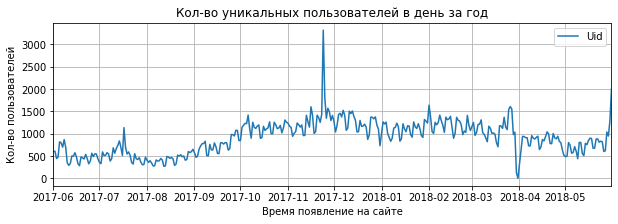

In [11]:
visits.groupby('ses_date').agg({'Uid': 'nunique'}).\
plot(grid=True, figsize=(10, 3), title = 'Кол-во уникальных пользователей в день за год')
plt.xlabel('Время появление на сайте')
plt.ylabel('Кол-во пользователей')

Text(0, 0.5, 'Кол-во пользователей')

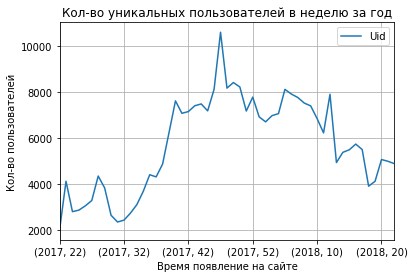

In [12]:
visits.groupby(['ses_year', 'ses_week']).agg({'Uid': 'nunique'}).\
plot(grid=True, title = 'Кол-во уникальных пользователей в неделю за год')
plt.xlabel('Время появление на сайте')
plt.ylabel('Кол-во пользователей')

Text(0, 0.5, 'Кол-во пользователей')

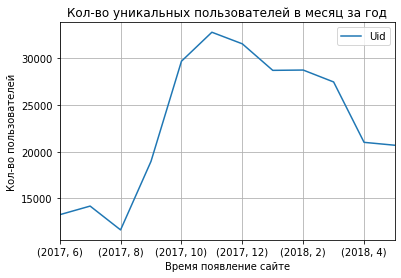

In [13]:
visits.groupby(['ses_year', 'ses_month']).agg({'Uid': 'nunique'}).\
plot(grid=True, title = 'Кол-во уникальных пользователей в месяц за год')
plt.xlabel('Время появление сайте')
plt.ylabel('Кол-во пользователей')

**Вывод:** Прослеживается активность большого числа пользователей под новый год в ноябре

**Сколько сессий совершает пользователь в день? Сколько в среденем длится одна сессия?
Посчитаем кол-во сессий в день сделанных за месяц пользователем.**

In [14]:
sessions_per_user = visits.groupby(['ses_year', 'ses_month']).agg({'Uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']

sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user

n_sessions  n_users  sess_per_user
ses_year ses_month                                    
2017     6               16505    13259           1.24
         7               17828    14183           1.26
         8               14355    11631           1.23
         9               23907    18975           1.26
         10              37903    29692           1.28
         11              43969    32797           1.34
         12              41983    31557           1.33
2018     1               36939    28716           1.29
         2               37182    28749           1.29
         3               35679    27473           1.30
         4               26515    21008           1.26
         5               26635    20701           1.29

Начертим гистограмму для понимания характера распределения. Для этого найдем среднюю длительность сессии 

Средняя длительность сессии: 643.506488592098


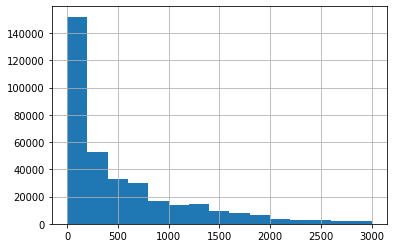

In [15]:
visits['session_duration_sec'] = (visits['End Ts'] - visits['Start Ts']).dt.seconds
print('Средняя длительность сессии:',visits['session_duration_sec'].mean())
visits['session_duration_sec'].hist(bins = 15, range = (0, 3000))

In [16]:
# распределение далеко от нормального. Рассчитаем моду, которая встречается чаще всего 
#(ASL - average session length)
asl = int(visits['session_duration_sec'].mode())
print('ASL:', asl)

ASL: 60


**Вывод** 

- ASL - 60 секунд. Пользователь совершайт активность в первую минуту; 
- 1 - 2 сессии на юзера в месяц - это лимит.

**Как часто люди возвращаются?
Рассчитаем Retetion Rate и сделаем когортный анализ**

In [17]:
# сгруппируем первую дату покупки пользователя в датафрейме orders
first_order_dates = orders.groupby('Uid')['Buy Ts'].min()

In [18]:
first_order_dates.name = 'first_order_dates'

In [19]:
# заджоиним first_order_dates с датафремом orders по столбцу Uid
orders = orders.join(first_order_dates, on ='Uid').reset_index()

In [20]:
# приведем столбецы с датой к типу дата и выделим месяц в отдельный столбец
orders['orders_month'] = pd.to_datetime(orders['Buy Ts'])
orders['first_order_dates'] = pd.to_datetime(orders['first_order_dates'])
orders['orders_month'] = orders['Buy Ts'].astype('datetime64[M]')
orders['first_order_month'] = orders['first_order_dates'].astype('datetime64[M]')

In [21]:
# cформируем сводную таблицу с когортами с изменением стоимости покупки 
orders_pivot = orders.\
pivot_table(index = 'first_order_month', columns = 'orders_month', values = 'Revenue', aggfunc = 'sum')
orders_pivot

orders_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,9557.49,981.82,885.34,1931.30,2068.58,1487.92,1922.74,1176.56,1119.15,1225.51,1155.66,519.62,nan
2017-07-01,nan,11557.65,644.61,1199.05,690.31,339.97,300.08,231.16,272.72,310.05,282.96,299.36,nan
2017-08-01,nan,nan,7228.83,646.63,628.12,536.05,676.85,388.45,288.61,554.86,400.33,257.53,nan
2017-09-01,nan,nan,nan,14568.53,2884.49,1344.52,10261.52,1033.84,1670.08,1810.85,627.57,474.92,nan
2017-10-01,nan,nan,nan,nan,21716.20,2325.21,830.65,682.01,657.77,522.37,368.10,501.14,nan
2017-11-01,nan,nan,nan,nan,nan,21036.26,1629.27,814.39,1326.13,604.04,219.88,469.02,nan
2017-12-01,nan,nan,nan,nan,nan,nan,20767.49,1141.22,4054.70,4669.10,1371.57,1481.66,nan
2018-01-01,nan,nan,nan,nan,nan,nan,nan,13949.50,994.22,1026.34,481.59,211.48,nan
2018-02-01,nan,nan,nan,nan,nan,nan,nan,nan,15177.16,1015.98,286.66,270.70,nan


In [22]:
# cформируем  данные по кагорте и месяцу совершения заказа
orders_grouped_by_cohorts = orders.groupby(['first_order_month', 'orders_month']).\
agg({'Revenue' : 'sum', 'Uid' : 'nunique'})
orders_grouped_by_cohorts.head()

Revenue   Uid
first_order_month orders_month               
2017-06-01        2017-06-01    9557.49  2023
                  2017-07-01     981.82    61
                  2017-08-01     885.34    50
                  2017-09-01    1931.30    54
                  2017-10-01    2068.58    88

In [23]:
# найдём средний чек 
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['Revenue'] / orders_grouped_by_cohorts['Uid']
# сформируем сводную таблицу по когортам и среднему чеку за месяц
orders_grouped_by_cohorts.\
pivot_table(index = 'first_order_month', values = 'revenue_per_user', columns = 'orders_month')

orders_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.72,16.10,17.71,35.76,23.51,22.21,31.01,25.03,19.30,27.23,25.68,9.80,nan
2017-07-01,nan,6.01,12.40,21.04,10.79,6.94,7.90,6.42,6.99,7.38,12.86,11.51,nan
2017-08-01,nan,nan,5.28,11.15,11.85,12.18,16.92,12.14,9.62,12.61,21.07,8.31,nan
2017-09-01,nan,nan,nan,5.64,22.19,13.45,138.67,19.88,26.10,27.44,16.96,11.04,nan
2017-10-01,nan,nan,nan,nan,5.00,11.29,6.75,7.41,7.07,7.26,6.57,7.48,nan
2017-11-01,nan,nan,nan,nan,nan,5.15,7.34,6.79,12.51,7.46,4.58,7.56,nan
2017-12-01,nan,nan,nan,nan,nan,nan,4.74,7.82,39.37,48.14,27.43,23.52,nan
2018-01-01,nan,nan,nan,nan,nan,nan,nan,4.14,8.72,12.37,11.20,4.70,nan
2018-02-01,nan,nan,nan,nan,nan,nan,nan,nan,4.16,8.61,4.94,6.94,nan


In [24]:
# внедрим lifetime когорты в таблицу
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['orders_month'] - orders_grouped_by_cohorts['first_order_month']

In [25]:
# преобразуем в число месяцев
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')

In [26]:
# округлим и переведём к числовому типу, для получения порядкого номера совершения покупки
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('Int64')

In [27]:
# когда все преобразования выполнены, оставим в обозначении когорты только год и месяц
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')

In [28]:
# сделаем сводную со средним чеком
revenue_per_user_pivot = orders_grouped_by_cohorts.\
pivot_table(index = 'first_order_month', columns = 'cohort_lifetime', values = 'revenue_per_user')
revenue_per_user_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.72,16.10,17.71,35.76,23.51,22.21,31.01,25.03,19.30,27.23,25.68,9.80
2017-07,6.01,12.40,21.04,10.79,6.94,7.90,6.42,6.99,7.38,12.86,11.51,nan
2017-08,5.28,11.15,11.85,12.18,16.92,12.14,9.62,12.61,21.07,8.31,nan,nan
2017-09,5.64,22.19,13.45,138.67,19.88,26.10,27.44,16.96,11.04,nan,nan,nan
2017-10,5.00,11.29,6.75,7.41,7.07,7.26,6.57,7.48,nan,nan,nan,nan
2017-11,5.15,7.34,6.79,12.51,7.46,4.58,7.56,nan,nan,nan,nan,nan
2017-12,4.74,7.82,39.37,48.14,27.43,23.52,nan,nan,nan,nan,nan,nan
2018-01,4.14,8.72,12.37,11.20,4.70,nan,nan,nan,nan,nan,nan,nan
2018-02,4.16,8.61,4.94,6.94,nan,nan,nan,nan,nan,nan,nan,nan


In [29]:
# рассчитаем Retation rate по активности на сайте
# определим первое вермя активности
first_visit_date = visits.groupby(['Uid'])['Start Ts'].min()

In [30]:
first_visit_date.name = 'first_visit_date'

In [31]:
# объединим с датафреймом 
visits = visits.join(first_visit_date, on = 'Uid')

In [32]:
# рассчитаем месяц визита
visits['visits_month'] = visits['Start Ts'].astype('datetime64[M]')
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')

In [33]:
# теперь для каждой строки датафрейма найдем lifetime пользователя в рамках когорты
visits = visits.reset_index()
visits['cohort_lifetime'] = visits['visits_month'] - visits['first_visit_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

In [34]:
# сгруппируем даные по кагорте и Lifetime
cohorts = visits.groupby(['first_visit_month','cohort_lifetime']).agg({'Uid':'nunique'}).reset_index()

In [35]:
# найдем число пользователей изначально бывших в когорте 
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','Uid']]

In [36]:
initial_users_count = initial_users_count.rename(columns = {'Uid' : 'cohort_users'})

In [37]:
# объединим данные по кагорте с исходными количеством пользователей в кагорте
cohorts = cohorts.merge(initial_users_count,on='first_visit_month')

In [38]:
# рассчитаем Retention Rate
cohorts['retention'] = cohorts['Uid'] / cohorts['cohort_users']

In [39]:
# когда все преобразования выполнены, оставим в обозначении когорты только год и месяц
cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m')

In [40]:
# построим сводную таблицу и тепловую карту
retention_pivot = cohorts.\
pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06,1.00,0.08,0.05,0.06,0.07,0.07,0.06,0.06,0.05,0.05,0.04,0.04
2017-07,1.00,0.06,0.05,0.06,0.06,0.05,0.05,0.05,0.04,0.03,0.03,nan
2017-08,1.00,0.08,0.06,0.06,0.05,0.04,0.04,0.04,0.03,0.03,nan,nan
2017-09,1.00,0.09,0.07,0.05,0.04,0.04,0.04,0.02,0.02,nan,nan,nan
2017-10,1.00,0.08,0.05,0.04,0.03,0.03,0.02,0.02,nan,nan,nan,nan
2017-11,1.00,0.08,0.04,0.04,0.03,0.02,0.02,nan,nan,nan,nan,nan
2017-12,1.00,0.06,0.04,0.03,0.02,0.02,nan,nan,nan,nan,nan,nan
2018-01,1.00,0.06,0.04,0.02,0.02,nan,nan,nan,nan,nan,nan,nan
2018-02,1.00,0.06,0.03,0.02,nan,nan,nan,nan,nan,nan,nan,nan


In [41]:
# посчитаем среднее значение возвращаемости по времени жизни
cohorts.pivot_table(columns='cohort_lifetime',values='retention') * 100

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
retention,100.00,6.52,4.63,4.28,4.06,3.94,3.70,3.75,3.55,3.52,3.41,4.50


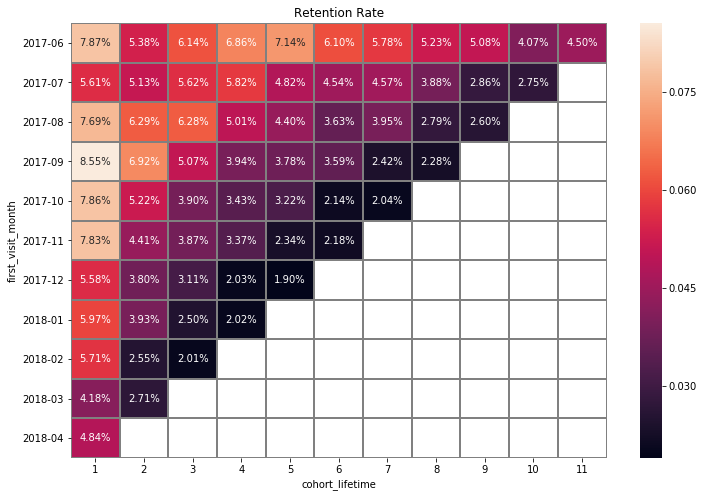

In [42]:
# отрежем нулевой месяц жизни, т.к. покупаемость 100;
retention_pivot = cohorts.query('cohort_lifetime > 0').\
pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
plt.figure(figsize=(12, 8))
plt.title('Retention Rate')
sns.heatmap(retention_pivot, fmt='.2%', annot=True, linewidths=1, linecolor='gray')

**Вывод:**
Retention падает почти в два раза к концу года с 7,8% до 4,5% у кагорты 2017-06. Нужно активировать инструменты удержания.

**Продажи**

- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)

- Когда люди начинают покупать?

In [43]:
# найдём первые устройства по визиту
visits_first = visits.groupby(['Uid'])['first_visit_date'].min()
# объединим с датафреймы и найдем дельту длительности от первого захода до заказа 
orders = orders.merge(visits_first, on = 'Uid').reset_index()
orders['order_time'] = orders['first_order_dates'] - orders['first_visit_date']
orders['order_time'] = orders['order_time'] / np.timedelta64(1,'s')

In [44]:
# взглянем на данные
orders['order_time'].describe()

count      50415.00
mean     1522139.44
std      4014648.11
min            0.00
25%          240.00
50%         1320.00
75%       373860.00
max     31388640.00
Name: order_time, dtype: float64

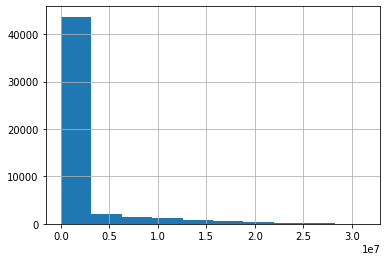

In [45]:
# посмотри на распределение длительности 
orders['order_time'].hist(bins = 10)

In [46]:
# Распределение далеко от нормального! 
# Вычислим моду
print('Мода:', int(orders['order_time'].mode()))

Мода: 0


**Вывод:** Похоже, что решение о покупке принимают в первые минуты. Просто заходят и берут. 

**Сколько раз покупают за период?**

In [47]:
# cформируем  данные по кагорте и месяцу совершения заказа
purchase_grouped_by_cohorts = orders.groupby(['first_order_month', 'orders_month']).\
agg({'Revenue' : 'count', 'Uid' : 'nunique'})
purchase_grouped_by_cohorts.head()

Revenue   Uid
first_order_month orders_month               
2017-06-01        2017-06-01       2354  2023
                  2017-07-01        177    61
                  2017-08-01        174    50
                  2017-09-01        226    54
                  2017-10-01        292    88

In [48]:
# найдём среднее число покупок количества покупок на каждого пользователя
purchase_grouped_by_cohorts['purchase_per_user'] = purchase_grouped_by_cohorts['Revenue'] / purchase_grouped_by_cohorts['Uid']
# сформируем сводную таблицу по когортам и среднему количеству покупок
purchase_grouped_by_cohorts.\
pivot_table(index = 'first_order_month', values = 'purchase_per_user', columns = 'orders_month')

orders_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,1.16,2.90,3.48,4.19,3.32,3.25,4.45,3.70,3.66,3.40,2.13,1.62,nan
2017-07-01,nan,1.14,1.92,2.11,1.62,1.47,2.16,1.69,1.28,1.38,1.09,2.04,nan
2017-08-01,nan,nan,1.12,1.86,1.89,1.84,2.12,1.94,1.63,1.77,2.42,1.48,nan
2017-09-01,nan,nan,nan,1.14,1.68,1.61,2.22,1.29,1.70,1.64,1.51,1.42,nan
2017-10-01,nan,nan,nan,nan,1.14,1.52,1.32,1.33,1.39,1.43,1.54,1.87,nan
2017-11-01,nan,nan,nan,nan,nan,1.18,1.79,1.52,1.99,1.68,1.23,1.65,nan
2017-12-01,nan,nan,nan,nan,nan,nan,1.15,1.85,1.96,1.85,1.72,1.67,nan
2018-01-01,nan,nan,nan,nan,nan,nan,nan,1.12,1.96,1.92,1.49,1.73,nan
2018-02-01,nan,nan,nan,nan,nan,nan,nan,nan,1.12,1.88,1.43,1.79,nan


In [49]:
# внедрим lifetime (переиоды) когорты в таблицу
purchase_grouped_by_cohorts = purchase_grouped_by_cohorts.reset_index()
purchase_grouped_by_cohorts['cohort_lifetime'] = purchase_grouped_by_cohorts['orders_month'] - purchase_grouped_by_cohorts['first_order_month']
# преобразуем в число месяцев
purchase_grouped_by_cohorts['cohort_lifetime'] = purchase_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
# округлим и переведём к числовому типу, для получения порядкого номера совершения покупки
purchase_grouped_by_cohorts['cohort_lifetime'] = purchase_grouped_by_cohorts['cohort_lifetime'].round().astype('Int64')
# когда все преобразования выполнены, оставим в обозначении когорты только год и месяц
purchase_grouped_by_cohorts['first_order_month'] = purchase_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')

In [50]:
# сделаем сводную, где покажем коммулятивный эффект кол-ва покупок в зависимости от времени жизни когорты
purchase_per_user_pivot = purchase_grouped_by_cohorts.query('cohort_lifetime < 6').\
pivot_table(index = 'first_order_month', columns = 'cohort_lifetime', values = 'purchase_per_user').\
cumsum(axis=1)
purchase_per_user_pivot

cohort_lifetime,0,1,2,3,4,5
first_order_month,,,,,,
2017-06,1.16,4.07,7.55,11.73,15.05,18.30
2017-07,1.14,3.06,5.17,6.79,8.26,10.42
2017-08,1.12,2.98,4.87,6.71,8.83,10.77
2017-09,1.14,2.82,4.43,6.65,7.94,9.64
2017-10,1.14,2.67,3.99,5.31,6.70,8.13
2017-11,1.18,2.97,4.48,6.47,8.15,9.38
2017-12,1.15,3.00,4.96,6.81,8.53,10.20
2018-01,1.12,3.09,5.00,6.49,8.22,nan
2018-02,1.12,3.00,4.43,6.23,nan,nan


Text(51.0, 0.5, 'Кагорта')

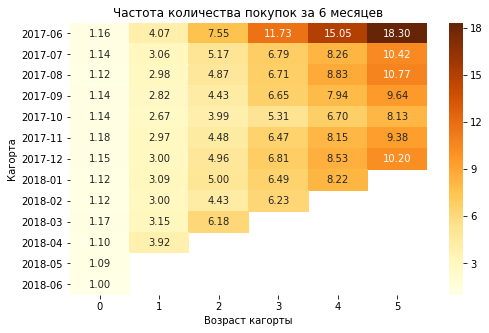

In [51]:
# визуализируем данные и построим тепловую карту
plt.figure(figsize = (8,5))
sns.heatmap(purchase_per_user_pivot, cmap="YlOrBr", annot = True, fmt='.2f')
plt.title('Частота количества покупок за 6 месяцев')
plt.xlabel('Возраст кагорты')
plt.ylabel('Кагорта')

In [52]:
# Расссчитаем среднее кол-во покупок для каждой кагорты
purchase_per_user_pivot.mean()

cohort_lifetime
0    1.13
1    3.16
2    5.11
3    7.02
4    8.96
5   10.98
dtype: float64

Количество покупок растёт из месяца в месяц. И суммарно выросло в 10 раз, что говорит о хорошему здоровье когорт. Но октябрьская когорта несколько выделяется в негативную сторону. ~ <b><font color=brown> Вывод!!! ~

**Какой средний чек?**

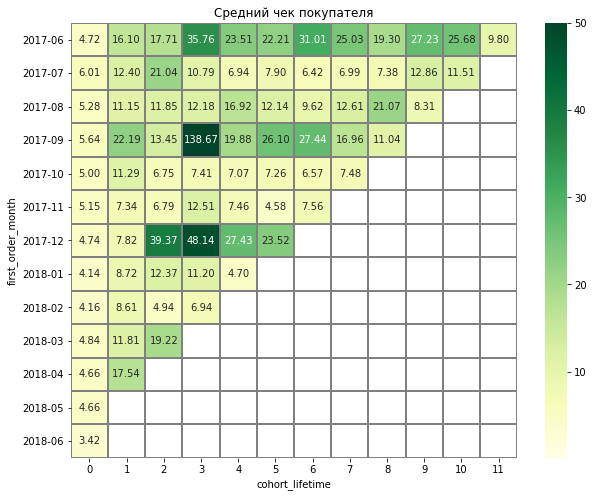

In [53]:
# визуализируем данные с среднего чека и построим тепловую карту
plt.figure(figsize = (10,8))
plt.title('Средний чек покупателя') #vmin=.1, vmax=1.8
sns.heatmap(revenue_per_user_pivot, annot = True, linewidths = 1, fmt='.2f', linecolor = 'gray', cmap="YlGn", vmin=.1, vmax=50)

In [54]:
# посмотрим на изменение среднего чека в динамике по месяцам
mean_bill = orders_grouped_by_cohorts.pivot_table(index = 'first_order_month', values = 'revenue_per_user')
# выведем самые продаваемые по среднему чеку 10 дней 
mean_bill.nlargest(10, 'revenue_per_user', keep='last')

,revenue_per_user
first_order_month,
2017-09,31.26
2017-12,25.17
2017-06,21.51
2017-08,12.11
2018-03,11.96
2018-04,11.10
2017-07,10.02
2018-01,8.22
2017-10,7.35


Text(0, 0.5, 'Средний чек')

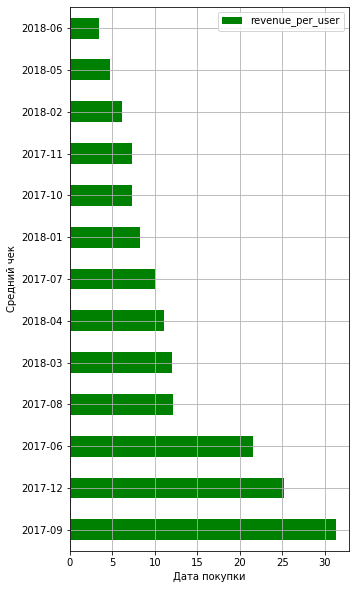

In [55]:
# изменение чека по графику
mean_bill.nlargest(20, 'revenue_per_user', keep='all').\
plot(kind = 'barh', figsize = (5, 10), grid = True, color = 'g', fontsize='10')
plt.xlabel('Дата покупки', fontsize=10)
plt.ylabel('Средний чек', fontsize=10)

**Вывод:**
- Самый покупаемый месяц по с/ч это декабрь - 30 у.е., наверное как-то связано с новым годом или устраивали мощные акции.
- Прослеживается сезонная тенденция. По кагортам 06-2017, 09-2017, 12-2017 самый жирный чек - 22, 25, 32 у.е., соотвественно. 

 - Сколько денег приносят? (LTV)

In [56]:
# выделим месяц из дат в таблице из бережно заранее сохраненного датасета - purchase
purchase['order_month'] = purchase['Buy Ts'].astype('datetime64[M]')
# получим первый месяц покупки каждого покупателя
first_orders_ltv = purchase.\
groupby('Uid').agg({'order_month': 'min'}).reset_index()
first_orders_ltv.columns = ['Uid', 'first_order_month']

In [57]:
# посчитаем кол-во новых покупателей за каждый месяц
cohort_sizes = first_orders_ltv.groupby('first_order_month').\
agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [58]:
# построим кагорты, добавим месяц первой покупки кадого покупателя в таблицу
ltv_orders =  pd.merge(purchase,first_orders_ltv, on='Uid')

In [59]:
# сгруппируем таблицу заказов по месяцу первой покупки и каждого заказа и сложим выручку
cohorts = ltv_orders.groupby(['first_order_month','order_month']).\
agg({'Revenue': 'sum'}).reset_index()

In [60]:
# добавим в cohorts данные сколько людей совершили первую покупку
ltv_df = pd.merge(cohort_sizes, cohorts, on = 'first_order_month')

In [61]:
# LTV считается из валовой прибыли, но для этого ещё нужно найти маржинальность
# Т.к. маржинальность нам не дана. Примем маржинальность margin_rate на едниницу - 1
margin_rate = 1
ltv_df['gp'] = ltv_df['Revenue'] * margin_rate
# посчитаем возраст кагорт
ltv_df['age'] = (ltv_df['order_month'] - ltv_df['first_order_month']) / np.timedelta64(1, 'M')
ltv_df['age'] = ltv_df['age'].round().astype('int')

In [62]:
ltv_df

,first_order_month,n_buyers,order_month,Revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4
...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2
75,2018-04-01,2276,2018-04-01,10600.69,10600.69,0
76,2018-04-01,2276,2018-05-01,1209.92,1209.92,1
77,2018-05-01,2988,2018-05-01,13925.76,13925.76,0


In [63]:
# посчитаем LTV. Разделим валовую прибыль на общее число покупателей по каждой когорте
ltv_df['ltv'] = ltv_df['gp']/ltv_df['n_buyers']

In [64]:
# выведем накопительный LTV каждой кагорты всех когорт возрастом 6 месяцев
ltv_cohorts = ltv_df.query('age < 6').\
        pivot_table(index='first_order_month', 
        columns='age', values='ltv', 
        aggfunc='mean').cumsum(axis=1)
ltv_cohorts

age,0,1,2,3,4,5
first_order_month,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28
2017-12-01,4.74,5.00,5.92,6.99,7.30,7.64
2018-01-01,4.14,4.43,4.73,4.88,4.94,nan
2018-02-01,4.16,4.44,4.51,4.59,nan,nan


In [65]:
# посчитаем сколько принёс в каждый покупатель из 2017-06-01 когорты за первые 6 месяцев
display("{:.2f}".format(ltv_cohorts.loc['2017-06-01'].sum()))

'38.17'

**Вывод!** Суммарное LTV за 6 месяцев для кагорты 2017-06-01 - 38.17.

Маркетинг

Сколько денег потратили? Всего / на каждый источник / по времени
Сколько стоило привлечение одного покупателя из каждого источника?
На сколько окупились расходы? (ROI)

**Сколько денег потратили? Всего / на каждый источник / по времени**

In [66]:
# просуммируем общую траты на маркетинг 
costs['costs'].sum()

329131.62

In [67]:
# просуммируем общую выручку
orders['Revenue'].sum()

252057.2

In [68]:
# посчитаем условную метрику эффектимности маркетинга без учёта себестоимости
mmmetrica = (orders['Revenue'].sum() - costs['costs'].sum())/costs['costs'].sum()
print(f'МММетрика: {(mmmetrica):.2%}')

МММетрика: -23.42%


In [69]:
source_costs = costs.groupby('source_id').agg({'costs' : 'sum'})
source_costs.nlargest(10, 'costs')

,costs
source_id,
3,141321.63
4,61073.60
5,51757.10
2,42806.04
1,20833.27
10,5822.49
9,5517.49


Text(0, 0.5, 'Затраты')

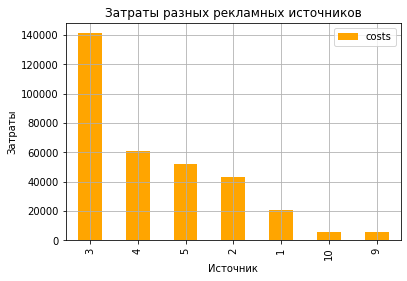

In [70]:
source_costs.nlargest(100, 'costs').plot(kind = 'bar', grid = True, color = 'orange')
plt.title('Затраты разных рекламных источников')
plt.xlabel('Источник')
plt.ylabel('Затраты')

Text(0, 0.5, 'Затраты')

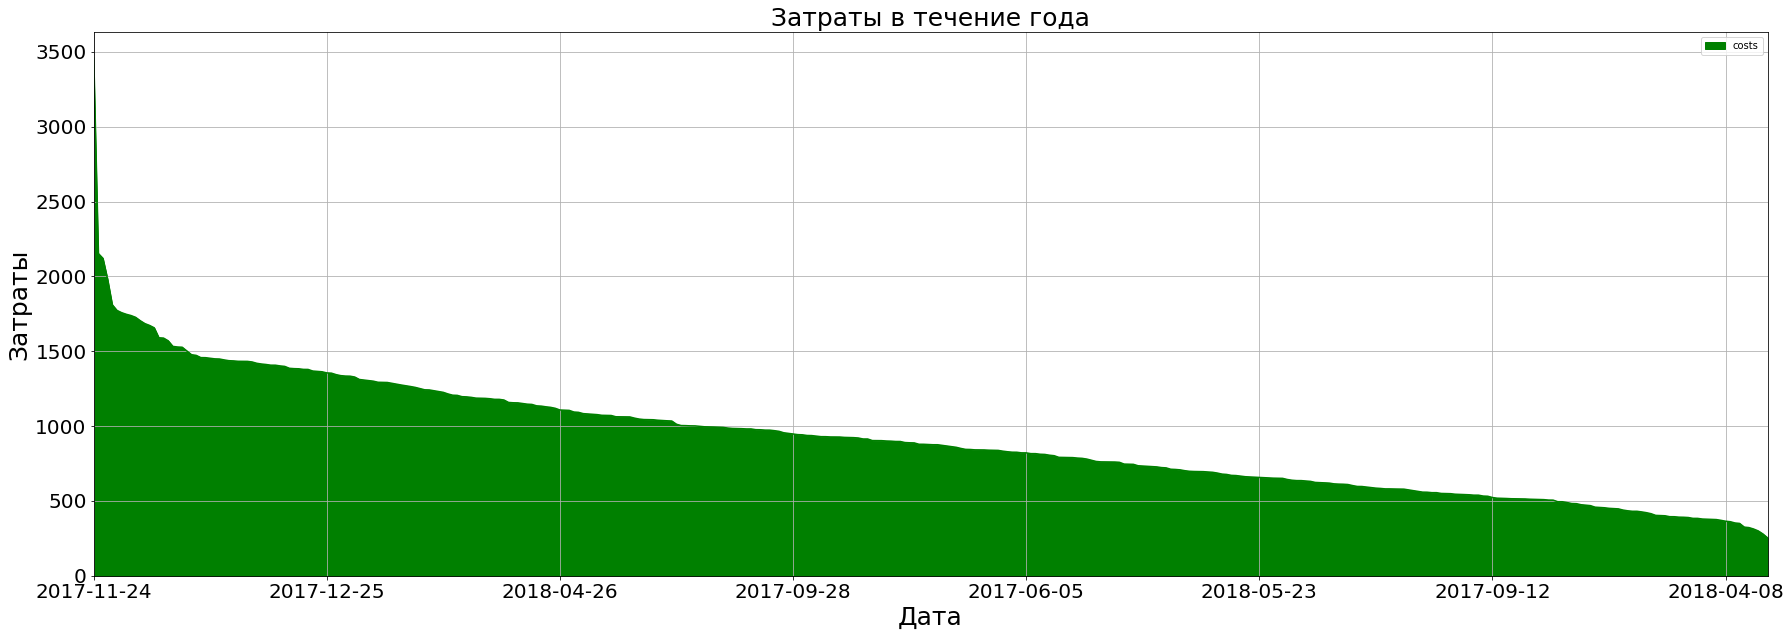

In [71]:
costs.groupby('dt').agg({'costs' : 'sum'}).nlargest(360, 'costs').\
plot(kind = 'area', figsize = (30, 10), grid = True, color = 'g', fontsize = 20)
plt.title('Затраты в течение года',  fontsize = 25)
plt.xlabel('Дата', fontsize = 25)
plt.ylabel('Затраты', fontsize = 25)

Text(0, 0.5, 'Затраты')

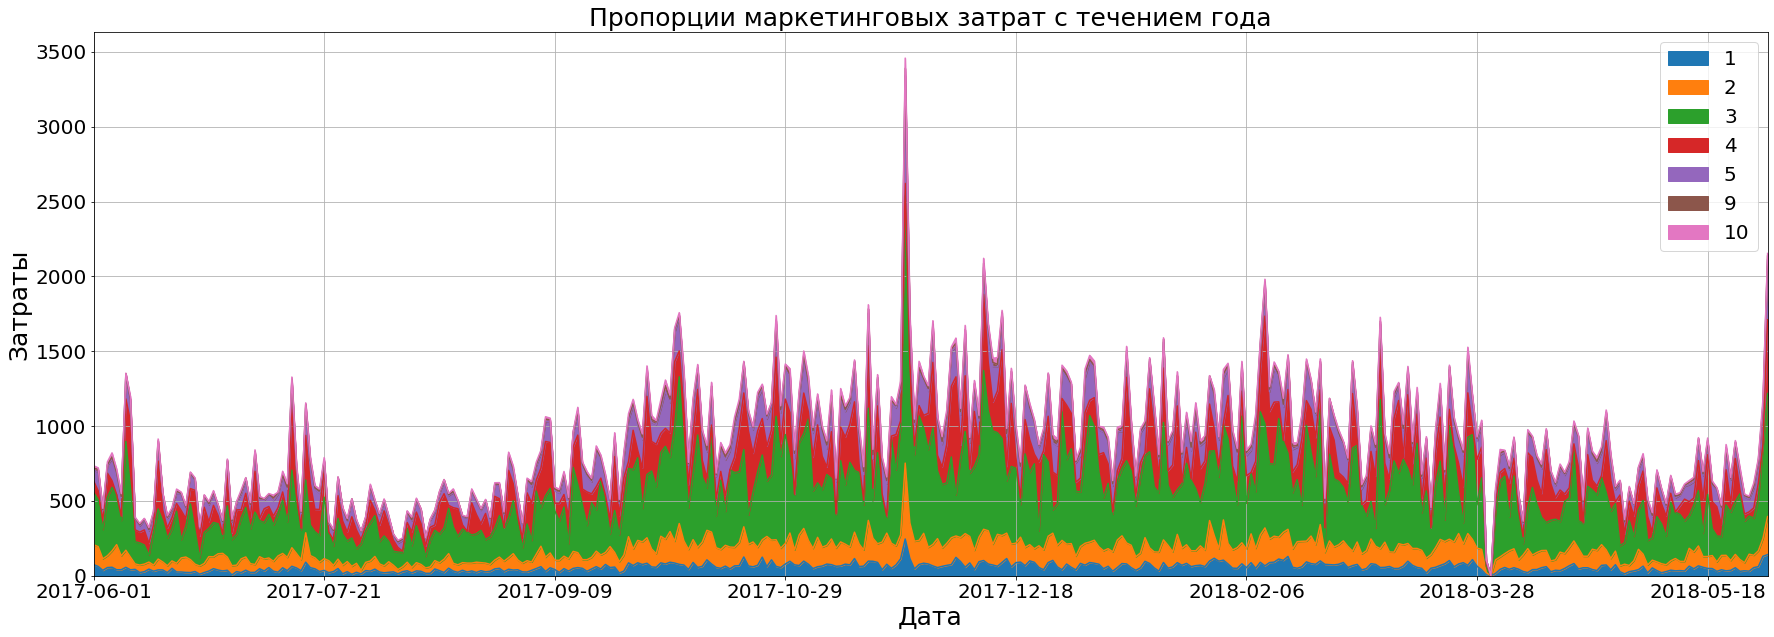

In [72]:
costs.\
pivot_table(index = 'dt', columns = 'source_id', 
            values = 'costs', aggfunc = 'sum').\
plot(kind = 'area', figsize = (30, 10), grid = True, fontsize = 20)

plt.legend(fontsize = 20)
plt.title('Пропорции маркетинговых затрат с течением года',  fontsize = 25)
plt.xlabel('Дата', fontsize = 25)
plt.ylabel('Затраты', fontsize = 25)

Выводы:
    - Маректинговые затраты не окупаются. Проект убыточный.
    - Больше всего денег уходит на 3ый рекламный источник
    - Затраты больше всего ложаться в конце ноября и канун нового года
    - Затраты на источники в течение года распределяются пропорционально

<div class="alert alert-block alert-success">
Здесь всё хорошо
</div>
    
---

**Сколько стоило привлечение одного покупателя из каждого источника?**

In [73]:
# найдём первые источники визита
source_uid = visits[['Uid', 'Source Id', 'Start Ts']].sort_values(by='Start Ts', ascending=True)
source_uid = source_uid.groupby(['Uid'])['Source Id'].first()

In [74]:
costs['first_order_month'] = costs['dt'].astype('datetime64[M]')
costs.head()

,source_id,dt,costs,first_order_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [75]:
costs_sum = costs.groupby(['first_order_month', 'source_id']).agg(costs_month = ('costs','sum')).reset_index()
costs_sum.head()

,first_order_month,source_id,costs_month
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


In [76]:
# добавим в orders источники
orders = pd.merge(orders, source_uid, on = 'Uid')
orders = orders.rename(columns = {'Source Id' : 'source_id'})
orders.head()

,level_0,index,Buy Ts,Revenue,Uid,first_order_dates,orders_month,first_order_month,first_visit_date,order_time,source_id
0,0,0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-06-01 00:09:00,60.00,1
1,1,1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01 00:14:00,660.00,2
2,2,2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-06-01 00:25:00,120.00,2
3,3,3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-06-01 00:14:00,900.00,2
4,4,4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-06-01 07:31:00,1620.00,3


In [77]:
# найдем уникальное число покупателей
cohort_source_1 = orders.groupby(['first_order_month','source_id', 'orders_month']).\
agg(n_buyers=('Uid','nunique')).reset_index()

In [78]:
# сгруппируем таблицу заказов по месяцу покупки
cohort_source_2 = orders.groupby(['first_order_month','source_id', 'orders_month']).\
agg(rev_per_m = ('Revenue','sum')).reset_index()

In [79]:
# объединим получившиеся таблички по source_id и first_order_month
main_df = cohort_source_1.merge(cohort_source_2,  on = ['source_id', 'first_order_month', 'orders_month']).\
merge(costs_sum,  on = ['source_id', 'first_order_month']).reset_index()

In [80]:
#найдем жизненный показатель - lifetime и рассчитаем ltv, cac и romi (margine_rate примем за 1)
main_df['lifetime'] = (main_df['orders_month'] - main_df['first_order_month']) / np.timedelta64(1, 'M')
main_df['first_order_month'] = main_df['first_order_month'].dt.strftime('%Y-%m-%d')
main_df['lifetime'] = main_df['lifetime'].round().astype('int')
margine_rate = 1
main_df['ltv'] = main_df['rev_per_m'] * margine_rate / main_df['n_buyers']
main_df['cac'] = main_df['costs_month'] / main_df['n_buyers']
main_df['romi'] = main_df['ltv'] / main_df['cac']
main_df.head()

,index,first_order_month,source_id,orders_month,n_buyers,rev_per_m,costs_month,lifetime,ltv,cac,romi
0,0,2017-06-01,1,2017-06-01,190,1378.70,1125.61,0,7.26,5.92,1.22
1,1,2017-06-01,1,2017-07-01,16,414.98,1125.61,1,25.94,70.35,0.37
2,2,2017-06-01,1,2017-08-01,10,419.43,1125.61,2,41.94,112.56,0.37
3,3,2017-06-01,1,2017-09-01,9,714.24,1125.61,3,79.36,125.07,0.63
4,4,2017-06-01,1,2017-10-01,12,811.20,1125.61,4,67.60,93.80,0.72


Text(69.0, 0.5, 'Кагорта')

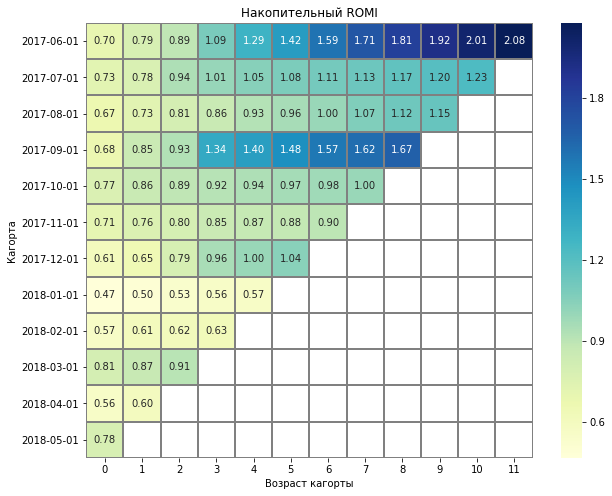

In [81]:
# построим тепловую карту накопительного ROMI и посчитаем по источникам
romi_heatmap = main_df.\
pivot_table(index = 'first_order_month', columns = 'lifetime', values = 'romi').cumsum(axis=1)

plt.figure(figsize = (10,8))
sns.heatmap(romi_heatmap, cmap="YlGnBu", annot = True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title('Накопительный ROMI')
plt.xlabel('Возраст кагорты')
plt.ylabel('Кагорта')

**Вывод:**
Не плохо! Просматривается квартальная тенденция. Каждые три месяца проект себя лучше окупает с каждой кагортой по маркетинговым затратам. Прибыль играет волнами по сезонам. Самые окупаемые кагорты показывают себя уже на 4 месяце жизни с результатом 1+.

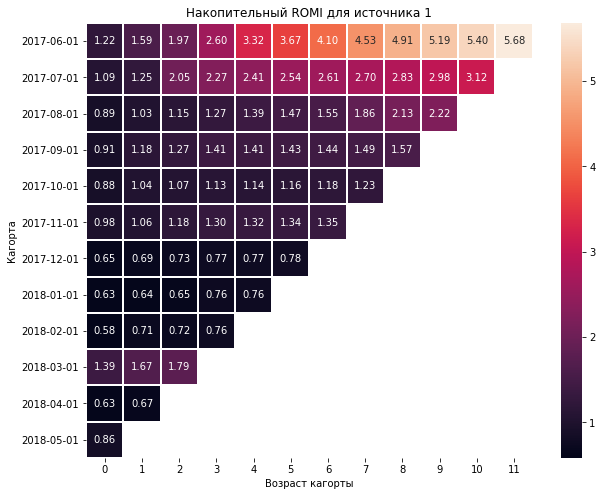

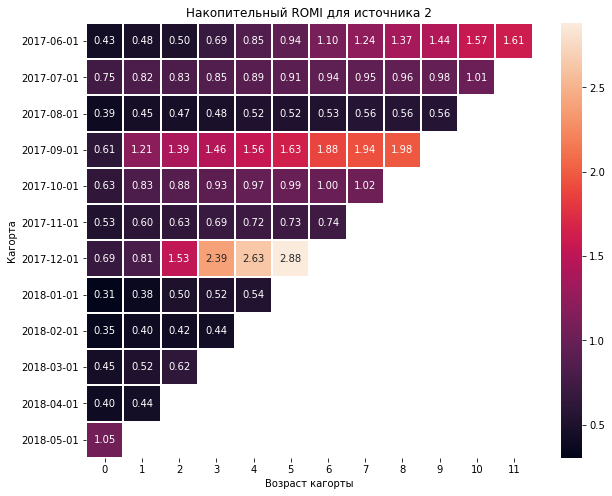

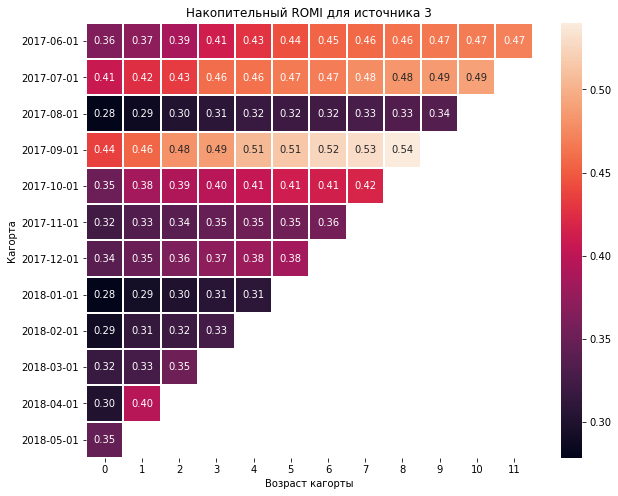

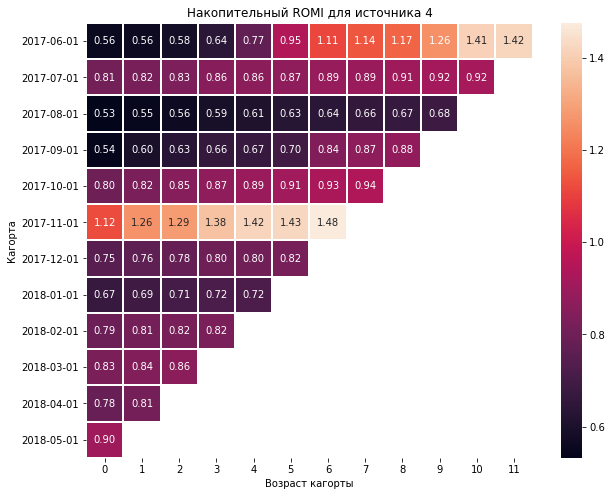

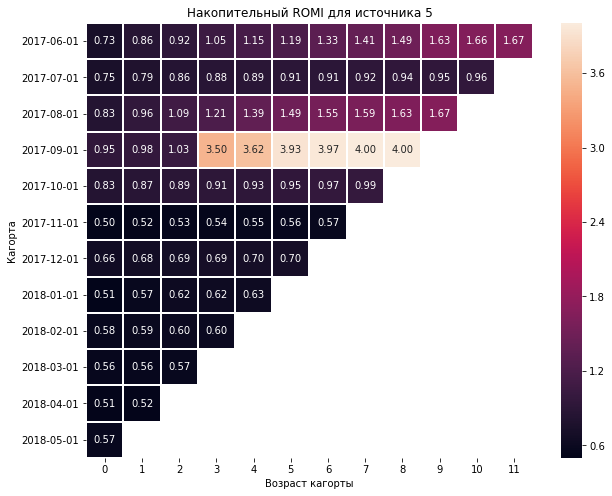

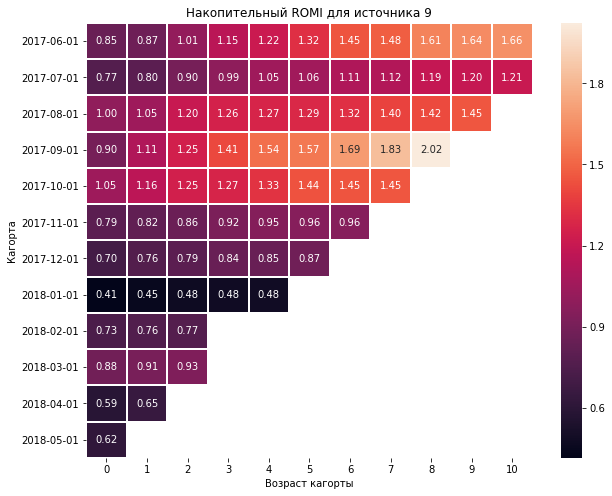

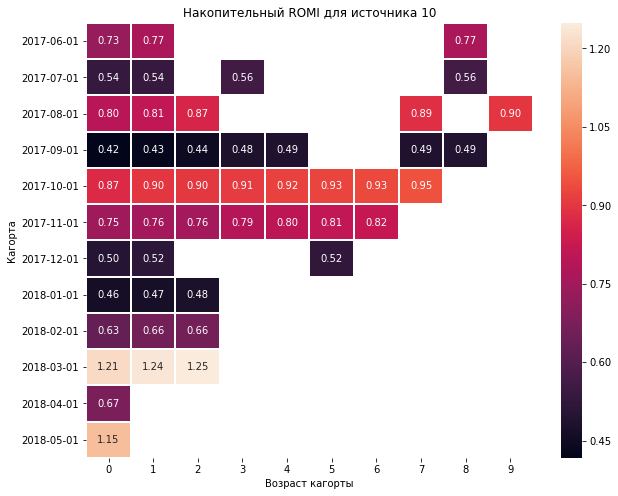

In [82]:
# построим ROMI по источникам, построим тепловую карту
for source in main_df['source_id'].unique():
    
        output = main_df.query('source_id == @source').pivot_table(
        index='first_order_month', 
        columns='lifetime', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1)
        plt.figure(figsize = (10, 8))
        ax = sns.heatmap(output, annot=True, fmt='.2f', linewidths=1)    
        
        ax.set_title('Накопительный ROMI для источника ' + str(source))
        ax.set_xlabel('Возраст кагорты')
        ax.set_ylabel('Кагорта')

In [83]:
# 10 источник по некоторым месяцам не участвовал в привлечениях. 
main_df.query('source_id == "10" and first_order_month == "2017-06-01"')

,index,first_order_month,source_id,orders_month,n_buyers,rev_per_m,costs_month,lifetime,ltv,cac,romi
71,71,2017-06-01,10,2017-06-01,95,229.35,314.22,0,2.41,3.31,0.73
72,72,2017-06-01,10,2017-07-01,2,11.06,314.22,1,5.53,157.11,0.04
73,73,2017-06-01,10,2018-02-01,1,0.85,314.22,8,0.85,314.22,0.00


**Вывод:**

10 источник по некоторым месяцам не участвовал в привлечениях, хотя денег в него уходит 220 у.е., почти как в 1ый источник который лучше всех окупается в первой кагорте сразу по первому месяцу жизни. Далее окупаемость катится вниз, видимо о нём позабыли. Стоит вернуться к раскрутке этого канала. 

С третьим источником всё плохо ROMI - 0.47 через год. А вот на 2, 5, 9 источник стоит перерасчитать часть рекламных.

Text(0, 0.5, 'Стоимость')

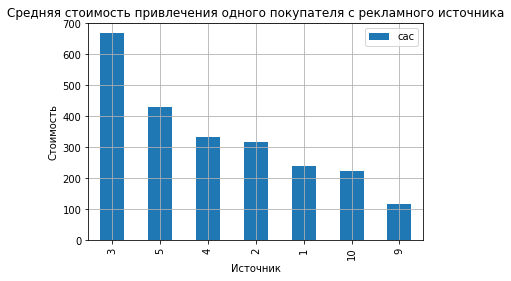

In [84]:
# посчитаем CAC по источникам 
main_df.groupby(['source_id']).agg({'cac': 'mean'}).\
sort_values('cac', ascending = False).plot(kind = 'bar', grid=True)
plt.title('Средняя стоимость привлечения одного покупателя с рекламного источника')
plt.xlabel('Источник')
plt.ylabel('Стоимость')

**Вывод:** 
Cтоимотсь привлечения за год пропорциональна общей стоимости привлечения. Самые затратные источники - 3 и 5. На них уходит 420 - 690 у.е. Остальные примерно 120-320 у.е.

,source_id,cac,ltv,romi
0,2,318.52,24.24,0.17
1,1,239.05,22.25,0.27
2,5,429.53,21.53,0.17
3,4,334.11,10.21,0.14
4,3,668.82,6.59,0.06
5,9,117.70,5.42,0.17
6,10,223.62,3.07,0.19


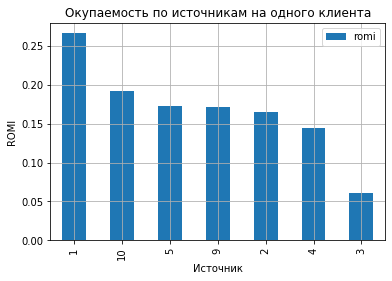

In [85]:
# посчитаем средний ROMI по источникам 
main_df.groupby(['source_id']).agg({'romi' : 'mean'}).\
sort_values('romi', ascending = False).plot(kind = 'bar', grid=True)
plt.title('Окупаемость по источникам на одного клиента')
plt.xlabel('Источник')
plt.ylabel('ROMI')
# построим таблицу 
main_df.groupby(['source_id']).agg({'cac': 'mean', 'ltv': 'mean', 'romi': 'mean'}).\
sort_values(by = ['ltv', 'cac', 'romi'], ascending = False).reset_index()

**Вывод:**

В целом картинка на покупателя плохая ROMI < 0.26. 
Проект убыточный, никакие источники себя не окупают по затратам на раскрутку. 
На 3ий источник стоит рассмотреть сокращение затрат ROMI < 0.06. 
Хотя возможно там дороже стоимость покупателя по сравнению со всеми.

**Отобразите на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?**

In [86]:
# посчитаем доли платформ по устройствам
device_part = visits.groupby('Device').agg(сnt = ('Uid','nunique'))
device_part

,сnt
Device,
desktop,164523
touch,71345


In [87]:
# доля touch устройств
device_part.query('Device == "touch"') / device_part.sum()

,сnt
Device,
touch,0.30


In [88]:
# отфильтруем таблицу по устройствам
visits['is_desktop'] = visits['Device']  == 'desktop'
visits['is_touch'] = visits['Device']  == 'touch'

In [89]:
# посчитаем метрики desktop
dau_desktop = int(visits[visits['is_desktop']].\
groupby(['ses_date']).agg({'Uid':'nunique'}).mean())
wau_desktop = int(visits[visits['is_desktop']].\
groupby(['ses_year', 'ses_week']).agg({'Uid':'nunique'}).mean())
mau_desktop = int(visits[visits['is_desktop']].\
groupby(['ses_year', 'ses_month']).agg({'Uid':'nunique'}).mean())
# посчитаем метрики touch
dau_touch = int(visits[visits['is_touch']].\
groupby(['ses_date']).agg({'Uid':'nunique'}).mean())
wau_touch = int(visits[visits['is_touch']].\
groupby(['ses_year', 'ses_week']).agg({'Uid':'nunique'}).mean())
mau_touch = int(visits[visits['is_touch']].\
groupby(['ses_year', 'ses_month']).agg({'Uid':'nunique'}).mean())
# выведем метрики
print(' DAU_desktop -', dau_desktop,'\n', 'WAU_desktop -', wau_desktop,'\n', 'MAU_desktop -', mau_desktop)
print('------------------------------------------------------------------------')
print(' DAU_touch -', dau_touch,'\n', 'WAU_touch -', wau_touch,'\n', 'MAU_touch -', mau_touch)
# посчитаем  месячный и недельный "липкий фактор". Как часто пользователи обращаются Афише
print('------------------------------------------------------------------------')
print(f'Недельный липкий фактор desktop: {(dau_desktop/wau_desktop):.3f}')
print("Месячный липкий фактор desktop: {:.3f}".format(dau_desktop/mau_desktop))
print('------------------------------------------------------------------------')
print(f'Недельный липкий фактор touch: {(dau_touch/wau_touch):.3f}')
print("Месячный липкий фактор touch: {:.3f}".format(dau_touch/mau_touch))

 DAU_desktop - 659 
 WAU_desktop - 4129 
 MAU_desktop - 16724
------------------------------------------------------------------------
 DAU_touch - 252 
 WAU_touch - 1634 
 MAU_touch - 6825
------------------------------------------------------------------------
Недельный липкий фактор desktop: 0.160
Месячный липкий фактор desktop: 0.039
------------------------------------------------------------------------
Недельный липкий фактор touch: 0.154
Месячный липкий фактор touch: 0.037


Text(0, 0.5, 'Кол-во пользователей')

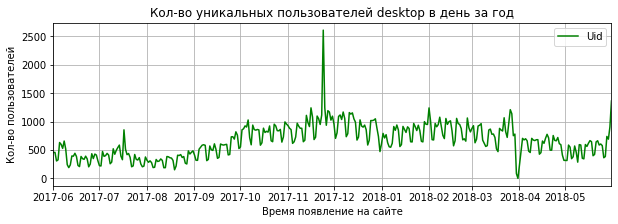

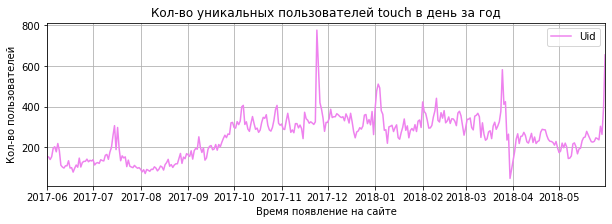

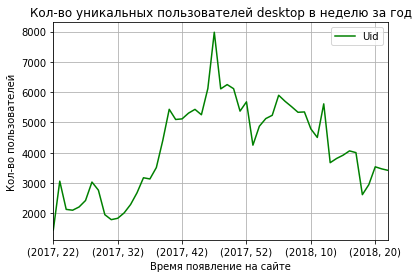

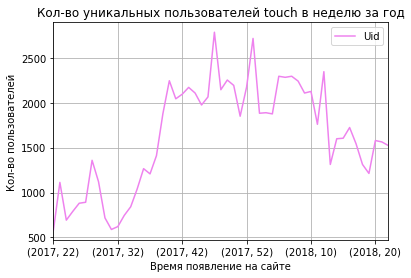

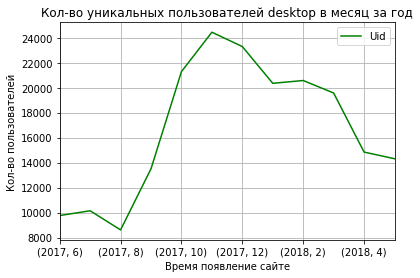

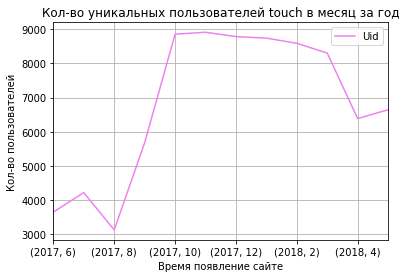

In [90]:
# рассмотрим как метрики меняются во времени
visits[visits['is_desktop']].groupby(['ses_date']).agg({'Uid':'nunique'}).\
plot(grid=True, figsize=(10, 3), title = 'Кол-во уникальных пользователей desktop в день за год', color = 'g')
plt.xlabel('Время появление на сайте')
plt.ylabel('Кол-во пользователей')

visits[visits['is_touch']].groupby(['ses_date']).agg({'Uid':'nunique'}).\
plot(grid=True, figsize=(10, 3), title = 'Кол-во уникальных пользователей touch в день за год', color = 'violet')
plt.xlabel('Время появление на сайте')
plt.ylabel('Кол-во пользователей')

visits[visits['is_desktop']].groupby(['ses_year', 'ses_week']).agg({'Uid': 'nunique'}).\
plot(grid=True, title = 'Кол-во уникальных пользователей desktop в неделю за год', color = 'g')
plt.xlabel('Время появление на сайте')
plt.ylabel('Кол-во пользователей')

visits[visits['is_touch']].groupby(['ses_year', 'ses_week']).agg({'Uid': 'nunique'}).\
plot(grid=True, title = 'Кол-во уникальных пользователей touch в неделю за год', color = 'violet')
plt.xlabel('Время появление на сайте')
plt.ylabel('Кол-во пользователей')

visits[visits['is_desktop']].groupby(['ses_year', 'ses_month']).agg({'Uid': 'nunique'}).\
plot(grid=True, title = 'Кол-во уникальных пользователей desktop в месяц за год', color = 'g')
plt.xlabel('Время появление сайте')
plt.ylabel('Кол-во пользователей')

visits[visits['is_touch']].groupby(['ses_year', 'ses_month']).agg({'Uid': 'nunique'}).\
plot(grid=True, title = 'Кол-во уникальных пользователей touch в месяц за год', color = 'violet')
plt.xlabel('Время появление сайте')
plt.ylabel('Кол-во пользователей')

**Вывод!** Поведение устройств почти не отличается и похож на всех графиках. Но с мобильных устройств оставляют длительную активность вплоть до февраля. UX / UI для них видимо хорошо спроектирован. Стоит его развивать и дальше! Изменение во времени всё также проходит. Липкий фактор недельный / месячный близки у обоих устройств 0.160 / 0.154 и 0.039 / 0.037.

**По устройства.**
 - Сколько сессий совершает пользователь в день? 
 - Сколько в среденем длится одна сессия?
 - Посчитаем кол-во сессий в день сделанных за месяц пользователем.

In [91]:
# посчитаем кол-во сессий
sessions_per_user_device = visits.groupby(['Device', 'ses_year', 'ses_month']).agg({'Uid': ['count','nunique']})
sessions_per_user_device.columns = ['n_sessions', 'n_users']
sessions_per_user_device['sess_per_user'] = sessions_per_user_device['n_sessions'] / sessions_per_user_device['n_users']

Text(0, 0.5, 'Кол-во сессий')

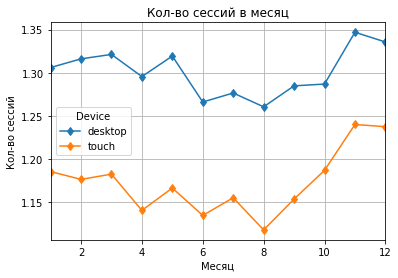

In [92]:
# визуализируем посчитанное
sessions_per_user_device.pivot_table(index = 'ses_month', columns = 'Device', values = 'sess_per_user').\
plot(grid=True, style = 'd-')
plt.title('Кол-во сессий в месяц')
plt.xlabel('Месяц')
plt.ylabel('Кол-во сессий')

In [93]:
# Рассчитаем ASL
asl_desktop = int(visits[visits['Device'] == 'desktop']['session_duration_sec'].mode())
asl_touch = int(visits[visits['Device'] == 'touch']['session_duration_sec'].mode())
print('ASL desktop:', asl_desktop)
print('ASL touch:', asl_touch)

ASL desktop: 60
ASL touch: 60


**Вывод** 
- ASL - 60 секунд. Пользователь совершайт активность в первую минуту c обоих устройств; 
- 1 - 2 сессии на юзера в месяц - это лимит, но с десктопа заходят по активней 1,3 против 1,2 сессеий.

**Когда люди начинают покупать с утройств?**

In [94]:
# найдём первые устройства по визиту
device = visits.groupby(['Uid'])['Device'].first()
# объединим с датафреймы 
orders_device = orders.merge(device, on = 'Uid')

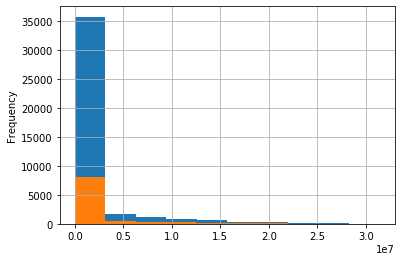

In [95]:
# посмотрим распределение desktop
orders_device[orders_device['Device'] == 'desktop']['order_time'].plot(kind = 'hist', bins = 10)
orders_device[orders_device['Device'] == 'touch']['order_time'].hist(bins = 10)

In [96]:
# распределения ненормальные! вычислим моду
order_time_desktop = int(orders_device[orders_device['Device'] == 'desktop']['order_time'].mode())
order_time_touch = int(orders_device[orders_device['Device'] == 'touch']['order_time'].mode())
print('Время на покупку desktop:', order_time_desktop)
print('Время на покупку touch:', order_time_touch)

Время на покупку desktop: 0
Время на покупку touch: 0


**Вывод:** 
Похоже, что решение о покупке принимают в первые минуты с любых устройств.

**Сколько раз покупают за период по устройствам?**

In [97]:
# cформируем данные по кагорте и месяцу совершения заказа с разных устройств
# найдём среднее число покупок и средний чек на каждого пользователя
device_grouped_by_cohorts = orders_device.\
groupby(['first_order_month', 'orders_month', 'Device']).\
agg(rev_cnt = ('Revenue','count'), uid_nunique = ('Uid','nunique'), rev_sum = ('Revenue','sum')).\
assign(purchase_per_user = lambda x: x['rev_cnt'] / x['uid_nunique'], 
       revenue_per_user = lambda x: x['rev_sum'] / x['uid_nunique']).reset_index()

In [98]:
# внедрим lifetime (переиоды) когорты в таблицу
device_grouped_by_cohorts['cohort_lifetime'] = device_grouped_by_cohorts['orders_month'] - device_grouped_by_cohorts['first_order_month']
# преобразуем в число месяцев
device_grouped_by_cohorts['cohort_lifetime'] = device_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
# округлим и переведём к числовому типу, для получения порядкого номера совершения покупки
device_grouped_by_cohorts['cohort_lifetime'] = device_grouped_by_cohorts['cohort_lifetime'].round().astype('Int64')
# когда все преобразования выполнены, оставим в обозначении когорты только год и месяц
device_grouped_by_cohorts['first_order_month'] = device_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')

Text(51.0, 0.5, 'Кагорта')

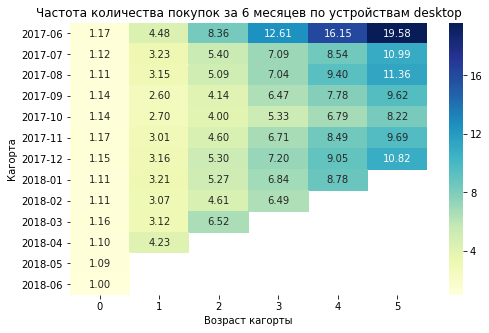

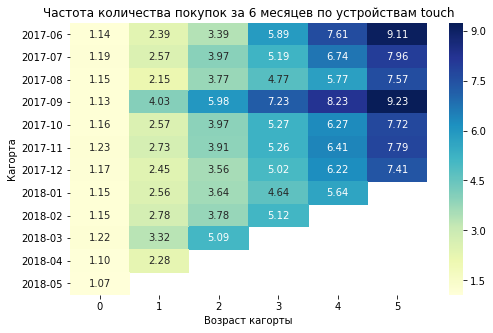

In [99]:
# сделаем сводную, где покажем коммулятивный эффект кол-ва покупок в зависимости от времени жизни когорты
desktop_per_user_pivot = device_grouped_by_cohorts.query('cohort_lifetime < 6 and Device == "desktop"').\
pivot_table(index = 'first_order_month', columns = 'cohort_lifetime', values = 'purchase_per_user').\
cumsum(axis=1)

touch_per_user_pivot = device_grouped_by_cohorts.query('cohort_lifetime < 6 and Device == "touch"').\
pivot_table(index = 'first_order_month', columns = 'cohort_lifetime', values = 'purchase_per_user').\
cumsum(axis=1)

# визуализируем данные и построим тепловую карту 
plt.figure(figsize = (8,5))
sns.heatmap(desktop_per_user_pivot, cmap="YlGnBu", annot = True, fmt='.2f')
plt.title('Частота количества покупок за 6 месяцев по устройствам desktop')
plt.xlabel('Возраст кагорты')
plt.ylabel('Кагорта')

plt.figure(figsize = (8,5))
sns.heatmap(touch_per_user_pivot, cmap="YlGnBu", annot = True, fmt='.2f')
plt.title('Частота количества покупок за 6 месяцев по устройствам touch')
plt.xlabel('Возраст кагорты')
plt.ylabel('Кагорта')

Text(0, 0.5, 'Среднее кол-во покупок')

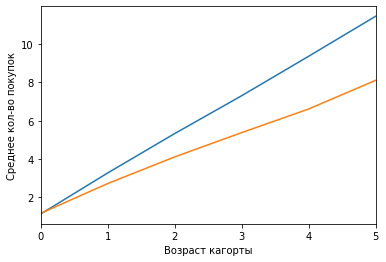

In [100]:
# Расссчитаем среднее кол-во покупок для каждой кагорты по устройствам и визуализируем
desktop_per_user_pivot.mean().plot()
touch_per_user_pivot.mean().plot()
plt.xlabel('Возраст кагорты')
plt.ylabel('Среднее кол-во покупок')

**Вывод!** Для кагорты 2017-06 которая прожила 6 месяцев число покупок прогрессивно растёт. Видимо всему виной проиближение нового года. Desktop больше touch в 2 раза!

**Какой средний чек?**

In [101]:
revenue_per_user_desktop = device_grouped_by_cohorts.query('Device == "desktop"').\
pivot_table(index = 'first_order_month', columns = 'cohort_lifetime', values = 'revenue_per_user')

revenue_per_user_touch = device_grouped_by_cohorts.query('Device == "touch"').\
pivot_table(index = 'first_order_month', columns = 'cohort_lifetime', values = 'revenue_per_user')

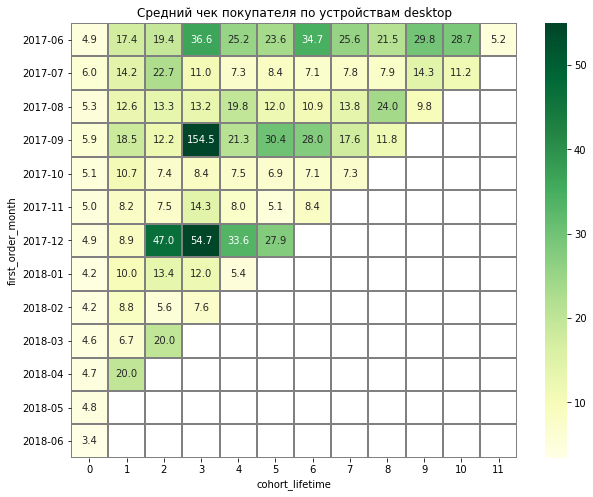

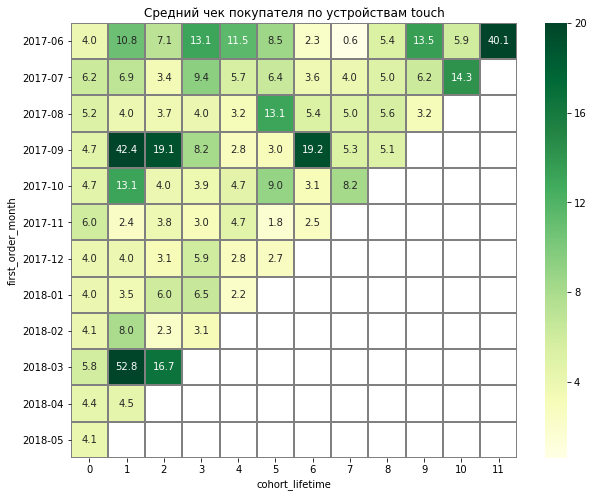

In [102]:
# визуализируем данные с среднего чека и построим тепловую карту
plt.figure(figsize = (10,8))
plt.title('Средний чек покупателя по устройствам desktop')
sns.heatmap(revenue_per_user_desktop, annot = True, linewidths = 1, 
            fmt='.1f', cmap="YlGn", linecolor = 'gray', vmax=55)

plt.figure(figsize = (10,8))
plt.title('Средний чек покупателя по устройствам touch')
sns.heatmap(revenue_per_user_touch, annot = True, linewidths = 1, 
            fmt='.1f', cmap="YlGn", linecolor = 'gray', vmax=20)

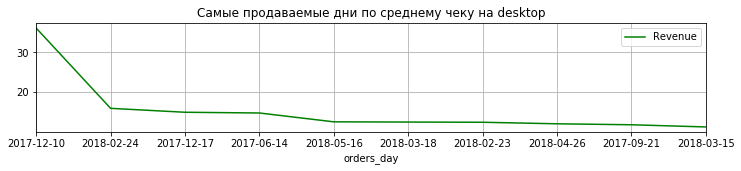

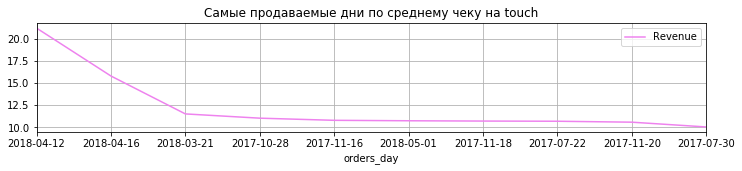

In [103]:
# найдём день оредра, и посмотрим на изменение среднего чека в динамике по дням
orders_device['orders_day'] = orders_device['Buy Ts'].astype('datetime64[D]')
orders_device['orders_day'] = orders_device['orders_day'].dt.strftime('%Y-%m-%d')
mean_bill_desktop = orders_device.query('Device == "desktop"').pivot_table(index = 'orders_day', values = 'Revenue')
mean_bill_touch = orders_device.query('Device == "touch"').pivot_table(index = 'orders_day', values = 'Revenue')
# выведем самые продаваемые по среднему чеку 10 дней 
mean_bill_desktop.nlargest(10, 'Revenue', keep='last').\
plot(grid = True, figsize = (12,2), title = 'Самые продаваемые дни по среднему чеку на desktop', color = 'g')
mean_bill_touch.nlargest(10, 'Revenue', keep='last').\
plot(grid = True, figsize = (12,2), title = 'Самые продаваемые дни по среднему чеку на touch', color = 'violet')

**Вывод:** 

Средний чек по Desktop первой кагорты видно сезонный мотив покупок. C touch устройств это менее заметно. Наблюдаются также моментные всплески с увеличение с/ч до 55 и 155 у desktop, и 40 и 50 у touch, видимо связаны с каким-то крупным собтием в мире афиши.

Самые продаваемые дни с desktop - 10/07/2017 с/ч = 38, touch - 12/04/2018 с/ч = 23

**Шаг 3. Напишем вывод**

**Итоговые выводы:**

**Продукт**

- Стоит обратить внимание на touch устройства их стоит лучше развивать. У пользователей по DAU и MAU к ним больший интерес. 
- UX / UI на тач устройствах, видимо хорошо спроектирован. Стоит его развивать и дальше! Потенциал у touch с долей в 30% больше, чем desktop в виду мобильности, и доля неумолимо будет расти. 

Липкие факторы на устройствах совпадают. Заначит, что тач у есть поле для привлечения:

Недельный desktop: 0.160

Месячный desktop: 0.039

Недельный touch: 0.154

Месячный touch: 0.037

- Retention падает почти в два раза к концу года с 7,8% до 4,5% у кагорты 2017-06. Такое же поведение и у остальных кагорт Нужно активировать инструменты удержания. 

- Дельта от покупки до визита минимальна. Похоже, что решение о покупке принимают в первые минуты с любых устройств.
- Стоило бы сделать в проекте задерживающиеся факторы, например на тех пользователей, кто ничего не покупает. Такое чувство, что проект служит лишь кассой без очереди. Нужно наполнять проект интресным контентом, чтобы пользователь туда заходил не только за покупками.

**Продажи**

- Условную метрика эффектимности маркетинга без учёта себестоимости минус 23%.
- Суммарное накопительное LTV за 6 месяцев для кагорты 2017-06-01 - 38.17.

- 1,3 сессий в месяц на пользователя. Кажется маловато. 

- Desktop, пока что покупает больше touch в 2 раза!

Общий средний чек.
- Самый покупаемый месяц по с/ч это декабрь - 30 у.е., наверное как-то связано с новым годом или устраивали мощные акции.
- Прослеживается сезонная тенденция. По кагортам 06-2017, 09-2017, 12-2017 самый жирный чек - 22, 25, 32 у.е., соотвественно.

Общий средний чек по устройствам.
- Общий средний чек покупателя по Desktop первой кагорты видно сезонный мотив покупок. C touch устройств это менее заметно. 
- Средний чек по Desktop первой кагорты видно сезонный мотив покупок. C touch устройств это менее заметно. Наблюдаются также моментные всплески с увеличение с/ч до 55 и 155 у desktop, и 40 и 50 у touch, видимо связаны с каким-то крупным собтием в мире афиши.
- Самые продаваемые дни с desktop - 10/07/2017 с/ч = 38, touch - 12/04/2018 с/ч = 23

**Маркетинг**

- Пиковая активность проявляется в перед новым годом. Хотя по ROMI просматривается квартальная тенденция. Каждые три месяца проект себя лучше окупает с каждой кагортой по маркетинговым затратам. Прибыль играет волнами по сезонам. Самые окупаемые кагорты показывают себя уже на 4 месяце жизни с результатом 1+. Стоит фиксировать эти пики в пользовательских посещениях и доводить визитёров до конца воронки.

- Судя по самой живучей когорте 2017-06-01, маркетинг окупает себя уже на 4 месяце жизни.

- 10 источник по некоторым месяцам не участвовал в привлечениях, хотя денег в него уходит 220 у.е., почти как в 1ый источник который лучше всех окупается в первой кагорте сразу по первому месяцу жизни. Далее окупаемость катится вниз, видимо о нём позабыли. Стоит вернуться к раскрутке этого канала. С третьим источником всё плохо ROMI - 0.47 через год. А вот на 2, 5, 9 источник стоит перерасчитать часть рекламных.

- Cтоимотсь привлечения за год пропорциональна общей стоимости привлечения. Самые затратные источники - 3 и 5. На них уходит 420 - 690 у.е. Остальные примерно 120-320 у.е.

- На одно покупателя ROMI < 0.26. Проект убыточный, никакие источники себя не окупают по затратам на раскрутку. На 3ий источник стоит рассмотреть сокращение затрат ROMI < 0.06. Хотя возможно там дороже стоимость привлечения покупателя по сравнению со всеми.

- Маректинговые затраты не окупаются. Проект убыточный.
- Больше всего денег уходит на 3ый рекламный источник
- Затраты больше всего ложаться в конце ноября и канун нового года
- Затраты на источники в течение года распределяются пропорционально